In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import seaborn as sns
import sqlite3

import chart_studio.plotly as py
import plotly.graph_objs as go

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 50)

In [4]:
# Creating a western US DataFrame from the database
conn = sqlite3.connect('RDS-2013-0009.4_SQLITE/Data/FPA_FOD_20170508.sqlite')
query = '''select * 
           from fires
           where STATE in ('WA', 'OR', 'CA', 'ID', 'NV', 'AZ', 'NM', 'UT', 'CO', 'WY', 'MT')'''
df = pd.read_sql_query(query, conn)

In [5]:
df.shape

(566684, 39)

In [6]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [7]:
df.describe()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE
count,5.666840e+05,5.666840e+05,566684.000000,5.666840e+05,566684.000000,566684.000000,4.202280e+05,420228.000000,566684.000000,566684.000000,566684.000000,566684.000000
mean,7.180089e+05,4.775504e+07,2003.015301,2.452844e+06,199.171717,4.759628,2.453019e+06,201.731367,132.765392,39.702435,-115.661553,7.534442
std,6.074726e+05,9.870046e+07,6.928333,2.528068e+03,58.494628,3.989823,2.558470e+03,56.093553,3125.793912,4.745308,5.613038,4.841033
min,1.000000e+00,1.000000e+00,1992.000000,2.448622e+06,1.000000,1.000000,2.448622e+06,1.000000,0.001000,31.332399,-124.718610,0.000000
25%,1.865328e+05,1.888158e+05,1997.000000,2.450630e+06,171.000000,1.000000,2.450932e+06,175.000000,0.100000,35.709685,-120.725867,5.000000
50%,3.938295e+05,4.274905e+05,2003.000000,2.452830e+06,204.000000,4.000000,2.452872e+06,206.000000,0.200000,39.170725,-116.667771,5.000000
75%,1.142179e+06,1.392038e+06,2009.000000,2.455016e+06,234.000000,9.000000,2.455280e+06,235.000000,1.000000,43.744203,-111.189444,14.000000
max,1.880465e+06,3.003484e+08,2015.000000,2.457388e+06,366.000000,13.000000,2.457388e+06,366.000000,558198.300000,49.001130,-102.054460,15.000000


In [8]:
df.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

In [12]:
# Checking for missing data
total = df.shape[0]
print(total)

566684


In [15]:
print('Missing data as a percentage of the total:')
for col in df.columns:
    missing = (df[col].isna()).sum()
    if missing > 0:
        print(col, ':', round((missing/total) * 100, 2))

Missing data as a percentage of the total:
LOCAL_FIRE_REPORT_ID : 50.22
LOCAL_INCIDENT_ID : 56.13
FIRE_CODE : 56.8
FIRE_NAME : 13.2
ICS_209_INCIDENT_NUMBER : 97.7
ICS_209_NAME : 97.7
MTBS_ID : 98.81
MTBS_FIRE_NAME : 98.81
COMPLEX_NAME : 99.29
DISCOVERY_TIME : 25.59
CONT_DATE : 25.84
CONT_DOY : 25.84
CONT_TIME : 30.53
COUNTY : 54.17
FIPS_CODE : 54.17
FIPS_NAME : 54.17


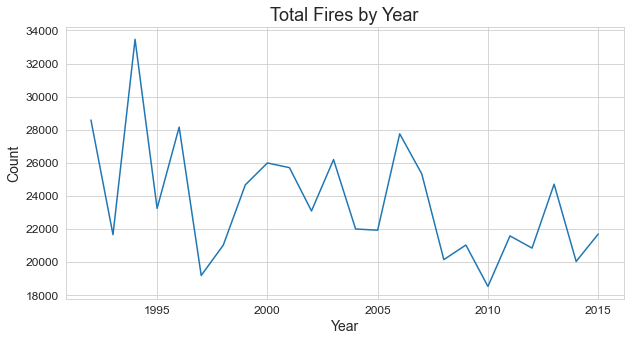

In [16]:
# Time series of causes of fire in the US

fires_by_year = df['FIRE_YEAR'].value_counts().reset_index(drop=False).sort_values('index')

plt.figure(figsize=(10,5))
sns.lineplot(data=fires_by_year, x='index', y='FIRE_YEAR')
plt.title('Total Fires by Year', size=18)
plt.xlabel('Year', size=14)
plt.xticks(size=12)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
plt.show()

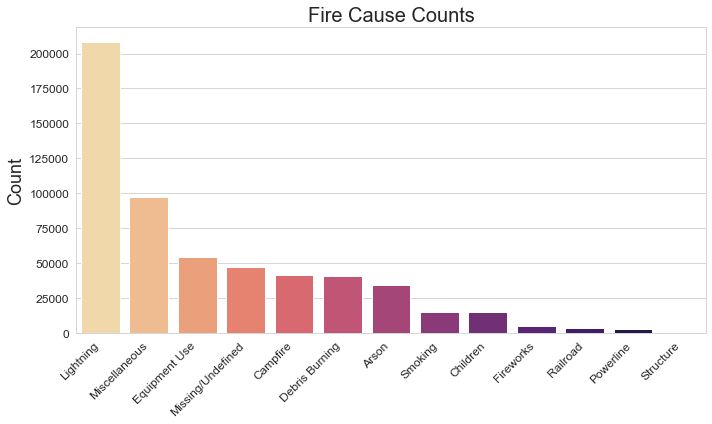

In [17]:
# Bar plot for class imbalance

cause_counts_full = pd.DataFrame(df['STAT_CAUSE_DESCR'].value_counts().reset_index(drop=False))

plt.figure(figsize=(10,6))
sns.barplot(x='index', y='STAT_CAUSE_DESCR', data=cause_counts_full, palette='magma_r')
plt.title('Fire Cause Counts', size=20)
plt.xlabel('')
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.ylabel('Count', size=18)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig./Figures/FireCausesCounts.pngpng', dpi=300)
plt.show()

### Converting dates, creating discovery month, and imputing discovery time

In [20]:
# Converting from Julian dates to Gregorian
epoch = pd.to_datetime(0, unit='s').to_julian_date()
df['DISC_GREG_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - epoch, unit='D')

epoch = pd.to_datetime(0, unit='s').to_julian_date()
df['CONT_GREG_DATE'] = pd.to_datetime(df['CONT_DATE'] - epoch, unit='D')

# Creating a discovery month feature
df['DISC_MONTH'] = df['DISC_GREG_DATE'].dt.month

# Imputing the missing dicovery times with the mean discovery time
disc_time_mean = pd.to_numeric(df['DISCOVERY_TIME'].dropna()).mean()
df['DISCOVERY_TIME'].fillna(disc_time_mean, inplace=True)



### Calculating the fire burn length, imputing containment date

In [22]:
# Creating a dataframe with date and size variables, dropping the NaN's
fire_dates = df[['DISCOVERY_DOY', 
                 'CONT_DOY',  
                 'FIRE_SIZE_CLASS']].copy()
fire_dates.dropna(inplace=True)

# Creating a variable for length of fire
fire_dates['Fire_length'] = fire_dates['CONT_DOY'] - fire_dates['DISCOVERY_DOY']

# Some fires that started and ended in different years are causing erroneous min/max values.
# Changing those values to NaN and then dropping them
fire_dates['Fire_length'].where((fire_dates['Fire_length'] < 300), np.NaN, inplace=True)
fire_dates['Fire_length'].where((fire_dates['Fire_length'] > 0), np.NaN, inplace=True)
fire_dates.dropna(inplace=True)


# Getting the mean `FIRE_LENGTH` by grouped `FIRE_SIZE_CLASS`
length_fireclass_mean = fire_dates.groupby('FIRE_SIZE_CLASS')['Fire_length'].mean()

# Creating a timedelta variable for each fire size class
fireclassA_length = pd.to_timedelta(length_fireclass_mean[0], unit='D')
fireclassB_length = pd.to_timedelta(length_fireclass_mean[1], unit='D')
fireclassC_length = pd.to_timedelta(length_fireclass_mean[2], unit='D')
fireclassD_length = pd.to_timedelta(length_fireclass_mean[3], unit='D')
fireclassE_length = pd.to_timedelta(length_fireclass_mean[4], unit='D')
fireclassF_length = pd.to_timedelta(length_fireclass_mean[5], unit='D')
fireclassG_length = pd.to_timedelta(length_fireclass_mean[6], unit='D')

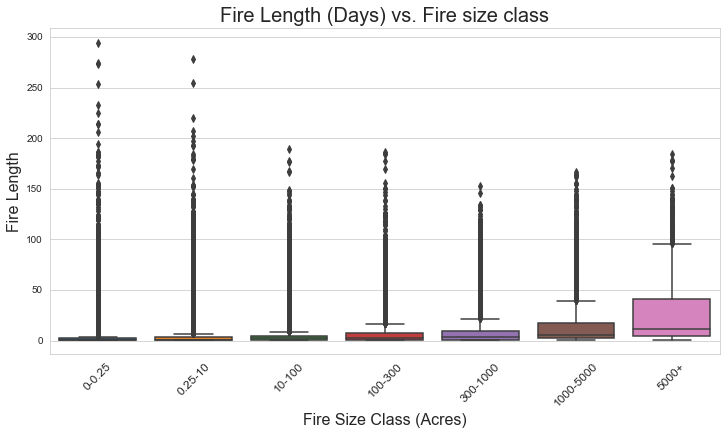

In [23]:
# Plot to show the imputation relationship between fire size and fire length
plt.figure(figsize=(12,6))
sns.boxplot(data=fire_dates, x='FIRE_SIZE_CLASS', y='Fire_length', 
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Fire Length (Days) vs. Fire size class', size=20)
plt.xlabel('Fire Size Class (Acres)', size=16)
plt.xticks([x for x in range(7)],
           ['0-0.25', '0.25-10', '10-100', '100-300', '300-1000', '1000-5000', '5000+'], 
           rotation=45, 
           size=12)
plt.ylabel('Fire Length', size=16)
plt.show()


In [24]:
def fireMeanLength(x):
    '''Function that returns a fire length for a given fire size class'''
    if x == 'A':
        return fireclassA_length
    elif x == 'B':
        return fireclassB_length
    elif x == 'C':
        return fireclassC_length
    elif x == 'D':
        return fireclassD_length
    elif x == 'E':
        return fireclassE_length
    elif x == 'F':
        return fireclassF_length
    elif x == 'G':
        return fireclassG_length

# Creating a new column in the main dataframe with the mean fire length
# by fire size group
df['FIRE_MEAN_LENGTH'] = df['FIRE_SIZE_CLASS'].apply(lambda x: fireMeanLength(x))

# Creating a column of calculated containment dates
df['Calc_CONT_DATE'] = df['DISC_GREG_DATE'] + df['FIRE_MEAN_LENGTH']

# Filling all missing data in CONT_GREG_DATE with the calculated date
df['CONT_GREG_DATE'].fillna(value=df['Calc_CONT_DATE'], inplace=True)

# Calculating the burn length of fire
df['FIRE_LENGTH'] = df['CONT_GREG_DATE'] - df['DISC_GREG_DATE']

# Changing the dtype of Fire_length to integer
df['FIRE_LENGTH'] = df['FIRE_LENGTH'].dt.days

### Dropping Missing/Undefined and Miscellaneous fire causes

In [25]:
# Dropping the Missing and Miscellaneous fire causes
df = df[~df['STAT_CAUSE_DESCR'].isin(['Miscellaneous', 'Missing/Undefined'])]

In [26]:
# List of causes to label the model confusion matrices
cause_labels = ['Lightning',
                'Equipment Use',
                'Smoking',
                'Campfire',
                'Debris Burning',
                'Railroad',
                'Arson',
                'Children',
                'Fireworks',
                'Powerline',
                'Structure']

### County FIPS code engineering

In [27]:
# Dropping any fire with a missing county-level `FIPS_CODE`
df = df.dropna(subset=['FIPS_CODE'], axis=0)


# Dictionary containing the abbreviated state name 
# and it's associated state-level FIPS code
state_FIPS = {
    'AZ': '04',
    'CA': '06',
    'CO': '08',
    'ID': '16',
    'MT': '30',
    'NV': '32',
    'NM': '35',
    'OR': '41',
    'UT': '49',
    'WA': '53',
    'WY': '56',
}

# Creating a new column with the State-level FIPS code
df['STATE_FIPS'] = df['STATE'].map(state_FIPS)

# Prepending the state code to the county code
df['FULL_FIPS'] = df[['STATE_FIPS', 'FIPS_CODE']].apply(''.join, axis=1)

# Dropping the parent columns to the FULL_FIPS columns
df.drop(columns=['FIPS_CODE', 'STATE_FIPS'], inplace=True)

### Full feature EDA

In [28]:
df.shape

(188018, 45)

In [29]:
# Getting the unique years and fire causes in the final data set
years = sorted(list(df['FIRE_YEAR'].unique()))
fire_causes = list(df['STAT_CAUSE_DESCR'].value_counts().index)

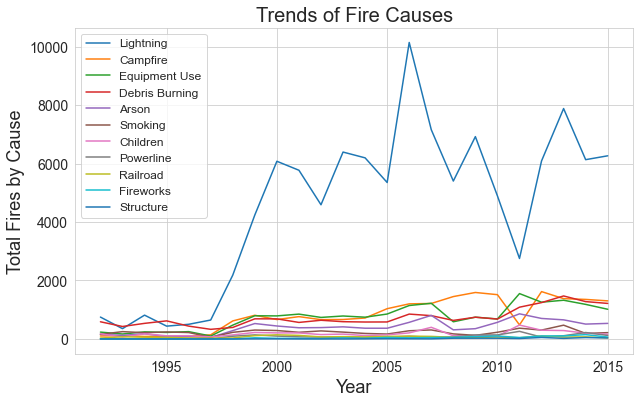

In [31]:
# Yearly time series of causes of fire in the US

# Empty DataFrame to fill iteratively
MW_fire_causes = pd.DataFrame({
    'Year': years,
    'Miscellaneous': np.zeros(24),
    'Missing/Undefined': np.zeros(24),
    'Lightning': np.zeros(24),
    'Debris Burning': np.zeros(24),
    'Arson': np.zeros(24),
    'Equipment Use': np.zeros(24),
    'Campfire': np.zeros(24),
    'Smoking': np.zeros(24),
    'Children': np.zeros(24),
    'Powerline': np.zeros(24),
    'Fireworks': np.zeros(24),
    'Railroad': np.zeros(24),
    'Structure': np.zeros(24),
})

# Iterating through years and causes, saving the number of fire causes per year to DataFrame
idx = 0
for yr in years:
    for cause in fire_causes:
        cause_value_count = df[(df['FIRE_YEAR'] == yr) & (df['STAT_CAUSE_DESCR'] == cause)].shape[0]
        MW_fire_causes.loc[idx, cause] = cause_value_count
    idx += 1

# Plotting time-series line plots for causes
plt.figure(figsize=(10,6))

for cause in fire_causes:
    sns.lineplot(data=MW_fire_causes, x='Year', y=cause)

plt.title('Trends of Fire Causes', size=20)
plt.legend(fire_causes, loc=2, fontsize=12)
plt.ylabel('Total Fires by Cause', size=18)
plt.yticks(size=14)
plt.xlabel('Year', size=18)
plt.xticks(size=14)
# plt.savefig('./Figures/FireCausesPerYear.png', dpi=300)
plt.show()

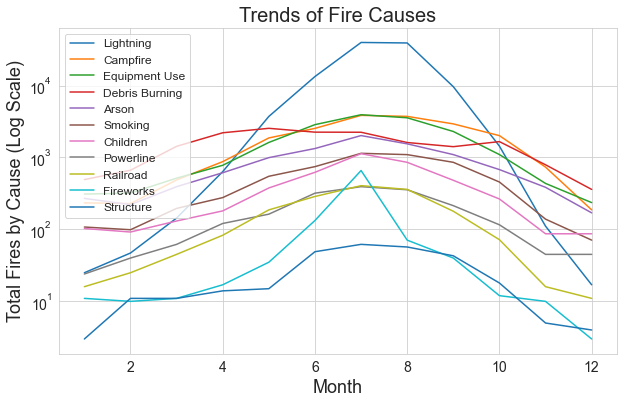

In [33]:
# Monthly time series of causes of fire in the US

months = [x for x in range(1,13)]

# Empty DataFrame to fill iteratively
MW_fire_causes_months = pd.DataFrame({
    'Month': months,
    'Miscellaneous': np.zeros(12),
    'Missing/Undefined': np.zeros(12),
    'Lightning': np.zeros(12),
    'Debris Burning': np.zeros(12),
    'Arson': np.zeros(12),
    'Equipment Use': np.zeros(12),
    'Campfire': np.zeros(12),
    'Smoking': np.zeros(12),
    'Children': np.zeros(12),
    'Powerline': np.zeros(12),
    'Fireworks': np.zeros(12),
    'Railroad': np.zeros(12),
    'Structure': np.zeros(12),
})

# Iterating through months and causes, saving the number of fire causes per year to DataFrame
idx = 0
for mn in months:
    for cause in fire_causes:
        cause_value_count = df[(df['DISC_MONTH'] == mn) & (df['STAT_CAUSE_DESCR'] == cause)].shape[0]
        MW_fire_causes_months.loc[idx, cause] = cause_value_count
    idx += 1

# Plotting time-series line plots for causes
plt.figure(figsize=(10,6))

for cause in fire_causes:
    sns.lineplot(data=MW_fire_causes_months, x='Month', y=cause)

plt.title('Trends of Fire Causes', size=20)
plt.legend(fire_causes, loc=2, fontsize=12)
plt.ylabel('Total Fires by Cause (Log Scale)', size=18)
plt.yticks(size=14)
plt.yscale('log')
plt.xlabel('Month', size=18)
plt.xticks(size=14)
# plt.savefig('./Figures/FireCausesPerYear.png', dpi=300)
plt.show()

             index  STAT_CAUSE_DESCR
0        Lightning            107934
1         Campfire             19682
2    Equipment Use             17969
3   Debris Burning             17673
4            Arson              9721
5          Smoking              5736
6         Children              4414
7        Powerline              1898
8         Railroad              1687
9        Fireworks              1012
10       Structure               292


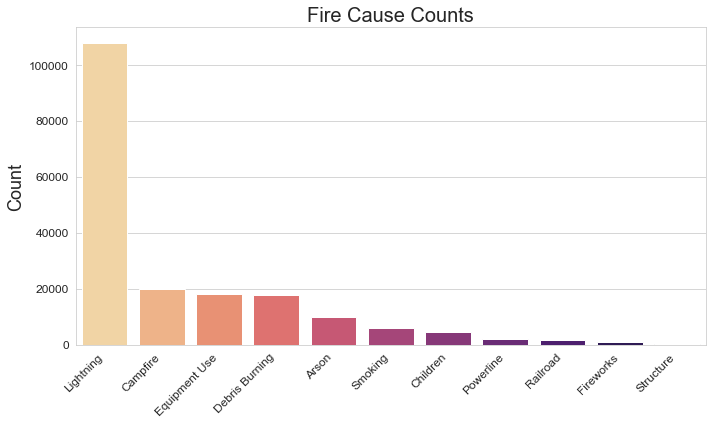

In [34]:
# Bar plot for class imbalance

cause_counts = pd.DataFrame(df['STAT_CAUSE_DESCR'].value_counts().reset_index(drop=False))
print(cause_counts)

plt.figure(figsize=(10,6))
sns.barplot(x='index', y='STAT_CAUSE_DESCR', data=cause_counts, palette='magma_r')
plt.title('Fire Cause Counts', size=20)
plt.xlabel('')
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.ylabel('Count', size=18)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig./Figures/FireCausesCounts.pngpng', dpi=300)
plt.show()

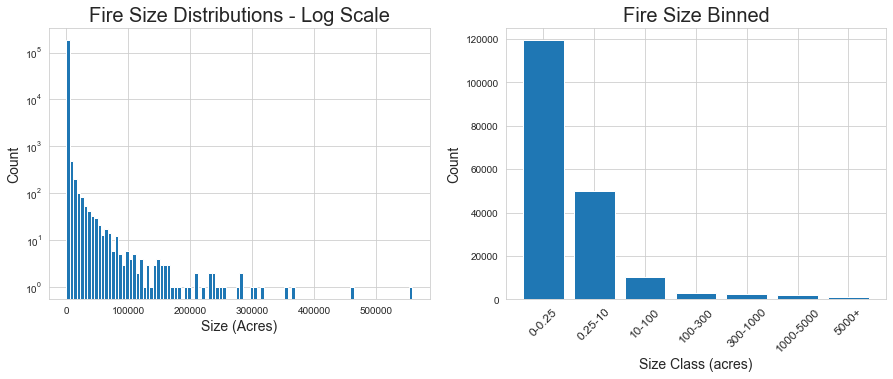

In [36]:
# Fire size distribution

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Fire Size Distributions - Log Scale', size=20)
plt.hist(df['FIRE_SIZE'], bins=100, log=True)
plt.xlabel('Size (Acres)', size=14)
plt.ylabel('Count', size=14)

plt.subplot(122)
plt.title('Fire Size Binned', size=20)
plt.bar(sorted(df['FIRE_SIZE_CLASS'].unique()), 
        height=df['FIRE_SIZE_CLASS'].value_counts().sort_index())
plt.xlabel('Size Class (acres)', size=14)
plt.xticks([x for x in range(7)],
           ['0-0.25', '0.25-10', '10-100', '100-300', '300-1000', '1000-5000', '5000+'], 
           rotation=45, 
           size=12)
plt.ylabel('Count', size=14)
plt.show()

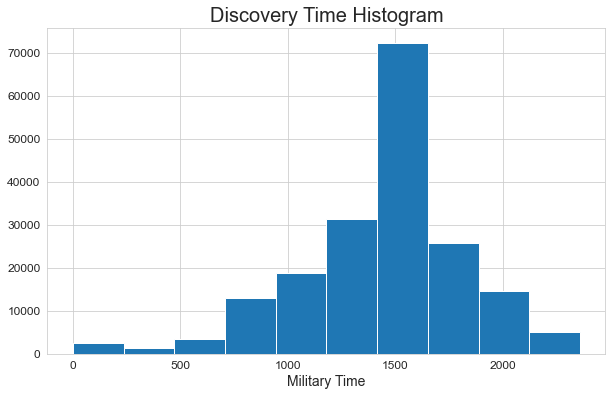

In [37]:
# Fire discovery time

plt.figure(figsize=(10,6))
plt.hist(pd.to_numeric(df['DISCOVERY_TIME']))
plt.title('Discovery Time Histogram', size=20)
plt.xlabel('Military Time', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

In [38]:
# Map of all fires used in analysis

# Base DataFrame with lat/long data
df_map = df[['STAT_CAUSE_CODE', 
             'FIRE_YEAR',
              'DISC_MONTH', 
              'DISCOVERY_TIME', 
              'FIRE_LENGTH', 
              'FIRE_SIZE_CLASS', 
              'STATE', 
              'FULL_FIPS', 
              'OWNER_DESCR', 
              'LATITUDE', 
              'LONGITUDE']]

# Colorbar
scl = 'Portland'

data = [go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_map['LONGITUDE'],
        lat = df_map['LATITUDE'],
        mode = 'markers',
        marker = dict( 
            size = 2, 
            opacity = 0.05,
            reversescale = False,
            symbol = 'circle',
            colorscale = scl,
            color = df_map['FIRE_YEAR'],
            cmax = 2005,
            cmin = 1992,
            colorbar=dict(
                title="Fire Year"
            )
        ))]

layout = dict(
        title = 'Fires of the Western US (1992-2015)', 
        geo = dict(
            scope = 'usa',
            projection = dict(type = 'albers usa', 
                              scale=1.35
                             ),
#             lonaxis = dict(range = [-125, -100]),
#             lataxis = dict(range = [30, 50]),
            center = dict(lon = -121, lat = 39),
            showland = True,
            showcountries = True,
            showsubunits = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(225, 225, 225)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 2,
            subunitwidth = 1
        ),
    )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='western_states_fires')

/Users/sruthiduvvuri/Documents/GitHub/predict-cause-of-Wildfires-in-US/venv/lib/python3.9/site-packages/chart_studio/plotly/plotly.py:222: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



PlotlyRequestError: Authentication credentials were not provided.

## Model Prep

In [39]:
# The base DataFrame for the model

df_base = df[['STAT_CAUSE_CODE', 
              'DISC_MONTH', 
              'DISCOVERY_TIME', 
              'FIRE_LENGTH', 
              'FIRE_SIZE_CLASS', 
              'STATE', 
              'FULL_FIPS', 
              'OWNER_DESCR']]

In [40]:
df_base.shape

(188018, 8)

In [41]:
df_base.head()

,STAT_CAUSE_CODE,DISC_MONTH,DISCOVERY_TIME,FIRE_LENGTH,FIRE_SIZE_CLASS,STATE,FULL_FIPS,OWNER_DESCR
1,1.0,5,0845,0,A,CA,06061,USFS
2,5.0,5,1921,0,A,CA,06017,STATE OR PRIVATE
3,1.0,6,1600,5,A,CA,06003,USFS
4,1.0,6,1600,5,A,CA,06003,USFS
5,1.0,6,1800,1,A,CA,06005,USFS


In [42]:
df_base.dtypes

STAT_CAUSE_CODE    float64
DISC_MONTH           int64
DISCOVERY_TIME      object
FIRE_LENGTH          int64
FIRE_SIZE_CLASS     object
STATE               object
FULL_FIPS           object
OWNER_DESCR         object
dtype: object

In [43]:
# Scaling the continuous input features
df_base['DISC_MONTH'] = scale(df_base['DISC_MONTH'].copy())
df_base['DISCOVERY_TIME'] = scale(df_base['DISCOVERY_TIME'].copy())
df_base['FIRE_LENGTH'] = scale(df_base['FIRE_LENGTH'].copy())

<ipython-input-43-734c523f703d>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-734c523f703d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-43-734c523f703d>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [79]:
print(df_base.head())

print(df_base.columns[[1,4]])

   STAT_CAUSE_CODE  DISC_MONTH  DISCOVERY_TIME  FIRE_LENGTH FIRE_SIZE_CLASS  \
1              1.0    -1.27347       -1.525197    -0.145800               A   
2              5.0    -1.27347        1.301495    -0.145800               A   
3              1.0    -0.68827        0.458216     0.121756               A   
4              1.0    -0.68827        0.458216     0.121756               A   
5              1.0    -0.68827        0.983623    -0.092289               A   

  STATE FULL_FIPS       OWNER_DESCR  
1    CA     06061              USFS  
2    CA     06017  STATE OR PRIVATE  
3    CA     06003              USFS  
4    CA     06003              USFS  
5    CA     06005              USFS  
Index(['DISC_MONTH', 'FIRE_SIZE_CLASS'], dtype='object')


In [44]:
def onehot(df, cols):
    '''One hot encode the categoricals, then drop the original columns'''
    for c in cols:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=c, inplace=True)
    return df

# Selecting the categorical features and OHE them
onehotcolumns = df_base.columns[-4:]
df_ohe_final = onehot(df_base, onehotcolumns)

In [45]:
df_ohe_final.shape

(188018, 449)

In [47]:
# Creating the target and input features
Y_ohe = df_ohe_final['STAT_CAUSE_CODE']
X_ohe = df_ohe_final.iloc[:, 1:].copy()

In [48]:
# We don't want OHE categorical variables in the Random Forest Model
# Reselecting the X values and encoding the categorical variables
df_rf_final = df_base.copy()

# Calling individual LabelEncoders for each categorical feature

# FIRE_SIZE_CLASS encoding
le_FSC = LabelEncoder()
df_rf_final['FIRE_SIZE_CLASS'] = le_FSC.fit_transform(df_rf_final['FIRE_SIZE_CLASS'])

# STATE encoding
le_STATE = LabelEncoder()
df_rf_final['STATE'] = le_STATE.fit_transform(df_rf_final['STATE'])

# FIPS encoding
le_FIPS = LabelEncoder()
df_rf_final['FULL_FIPS'] = le_FIPS.fit_transform(df_rf_final['FULL_FIPS'])

# OWNER DESCR encoding
le_OWN = LabelEncoder()
df_rf_final['OWNER_DESCR'] = le_OWN.fit_transform(df_rf_final['OWNER_DESCR'])

In [49]:
df_rf_final.shape

(188018, 8)

In [50]:
# Creating the target and input features
Y_rf = df_rf_final['STAT_CAUSE_CODE']
X_rf = df_rf_final.iloc[:, 1:].copy()

In [51]:
# Splitting the data, using stratify because of the class imbalance and 
# random state because we will need to do this split for linear models and tree-based models
X_train, X_test, Y_train, Y_test = train_test_split(X_ohe, 
                                                    Y_ohe, 
                                                    stratify=Y_ohe, 
                                                    random_state=93692)

# Resplitting the data with the random forest X inputs
X_rf_train, X_rf_test, Y_rf_train, Y_rf_test = train_test_split(X_rf, 
                                                                Y_rf, 
                                                                stratify=Y_ohe, 
                                                                random_state=93692)

In [52]:
print('Split data shapes')
print('X_train', X_train.shape)
print('X_rf_train', X_rf_train.shape)
print('X_test', X_test.shape)
print('X_rf_test', X_rf_test.shape)

Split data shapes
X_train (141013, 448)
X_rf_train (141013, 7)
X_test (47005, 448)
X_rf_test (47005, 7)


In [53]:
print('Split data fire cause counts')
print('Y_train')
print(Y_train.value_counts(), '\n')
print('Y_test')
print(Y_test.value_counts())

Split data fire cause counts
Y_train
1.0     80950
4.0     14761
2.0     13477
5.0     13255
7.0      7291
3.0      4302
8.0      3310
11.0     1424
6.0      1265
10.0      759
12.0      219
Name: STAT_CAUSE_CODE, dtype: int64 

Y_test
1.0     26984
4.0      4921
2.0      4492
5.0      4418
7.0      2430
3.0      1434
8.0      1104
11.0      474
6.0       422
10.0      253
12.0       73
Name: STAT_CAUSE_CODE, dtype: int64


## Initial Models

### Logistic Regression Models

In [54]:
# Best ridge logistic regression model from the grid search
ridge = LogisticRegression(solver='lbfgs', 
                           penalty='l2', 
                           multi_class='multinomial', 
                           C=.9, 
                           max_iter=500, 
                           n_jobs=3)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)

# Calculating model metrics
BalAccTst = balanced_accuracy_score(Y_test, Y_pred_ridge)
WF1Tst = f1_score(Y_test, Y_pred_ridge, average='weighted')
# class_report = classification_report(Y_test, Y_pred, labels=cause_labels)  # Error due to some classes not predicted

print('Balanced Accuracy :', BalAccTst)
print('Weighted F1 :', WF1Tst)
# print(class_report)

# Total number of predictions per class from the ridge model.
ridge_results = pd.DataFrame(Y_pred_ridge)[0].value_counts()
print(ridge_results)

Balanced Accuracy : 0.20986699702977293
Weighted F1 : 0.6040655464928459
1.0     34023
2.0      4993
5.0      4829
4.0      2062
7.0       712
3.0       268
11.0       58
8.0        31
6.0        18
10.0       11
Name: 0, dtype: int64


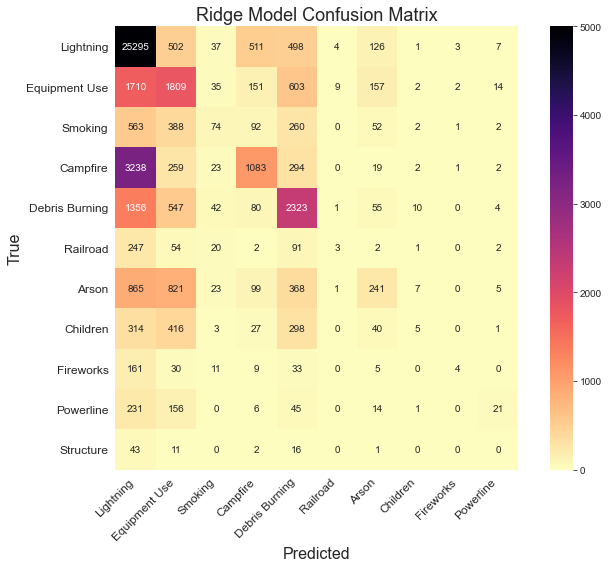

In [56]:
# Ridge confusion matrix
ridge_cfmx = pd.crosstab(Y_test, Y_pred_ridge)

ridge_labels = ['Lightning',
                'Equipment Use',
                'Smoking',
                'Campfire',
                'Debris Burning',
                'Railroad',
                'Arson',
                'Children',
                'Fireworks',
                'Powerline']

plt.figure(figsize=(10,8))
sns.heatmap(ridge_cfmx, 
            xticklabels = ridge_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('Ridge Model Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('./Figures/Ridge_lbfgs_c0.9_cfmx.png', dpi=300, transparent=True)
plt.show()

### Logistic Regression - Approach 2

In [64]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)

In [65]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe,Y_ohe, test_size=0.3)